In [2]:
# Imports
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
# Only useful for GPU devices
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices: tf.config.experimental.set_memory_growth(device, True)

In [4]:
# This loads in the dataset. Thankfully, TensorFlow already has methods to load this dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize input values
x_train = x_train/255.
x_test = x_test/255.

# Generate 32x32 image set for use in LeNet
cnn_x_train = np.pad(x_train, ((0,0),(2,2),(2,2))).reshape((-1, 32, 32, 1))
cnn_x_test = np.pad(x_test, ((0,0),(2,2),(2,2))).reshape((-1, 32, 32, 1))

# Resize images for use in MLP
mlp_x_train = x_train.reshape((x_train.shape[0], 784))
mlp_x_test = x_test.reshape((x_test.shape[0], 784))

# A Guided Look at CNNs Using MNIST
## Introduction

In this guided notebook, we will be implementing the most basic CNN for MNIST numeber classification, LeNet. We will start first with a simple analysis of the MNIST dataset to familiarize ourselves with the problem context. Later, we will then reintroduce the basic CNN concepts and how TensorFlow can be used to implement them. Finally, the system will be put together and used to classify the digits. An extra analysis portion will be added at the very end, but students are not required to execute this part on their own since it will take some time to properly generate the visual results.

## A View of MNIST

![MNIST Image](./images/mnist.png)

The MNIST dataset is a dataset that consists of a collection of handwritten numbers. These numbers are all single digits and thus only vary from 0-9 and have size ($28 \times 28$). Their initial purpose was to aid character recognition on handwritten letters through an SVM classification. While the SVM classification is normally a convenient way of being able to make comparisons of computational and spacial usage, that will be omitted for this section. For now, it is sufficient to know that a properly trained SVM can attain an error rate of approximately $0.8\%$; ideally, our convolutional network should perform better on the testing set since a typical CNN is often more expressive than an SVM and thus can represent the non-linearities better.

## Problem Specification

Much like the previous exercise, this question is also a classification problem. In probabilistic terms, this amounts to finding the class $i$ that maximizes the conditional probability density $P(Y=i|X=x_k)$. In other words, our classification can be framed in terms of the following optimization problem: $$y = \max_i P(Y=i|X=x_k) = \max_i f(x_k;W),\ f(x)\in\left[0,1\right]$$

Like before, we are free to choose whatever way we want in order to estimate the conditional probability. One possible way of estimating this density would be to use the MLP network we previously used for a supervised task. We can organize the images into columns of size $784$ and thus have an initial layer with $784$ inputs. What follows would then just be a couple layers with any numer of neurons leading to a final layer with 10 neurons using a softmax output. The softmax ensures that the 10 classes are properly normalized and are equivalent to a mutually exclusive probability distribution over $Y$ (as desired by the problem specification). For simplicity, let's just consider using the model from the previous MLP section for this problem and see what happens with the number of parameters.

In [3]:
# Implements the network using TensorFlow.Keras
def MLPNetwork(inputDim):
    # input layer (note that batches are already taken care of for you)
    x = keras.Input(shape=(inputDim,))
    
    # subsequent dense layers
    a1 = keras.layers.Dense(512, activation='relu')(x)
    a2 = keras.layers.Dense(512, activation='relu')(a1)
    
    # classification dense layer
    logits = keras.layers.Dense(10, activation='softmax')(a2)
    
    # Creates the model given the above structure
    model = keras.Model(inputs=x, outputs=logits)
    return model

MLPmod = MLPNetwork(784)
MLPmod.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


In [4]:
# Sets up optimizer
opt = keras.optimizers.Adam(learning_rate=0.001)
MLPmod.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# The callback forces the network to train until it reaches 100% accuracy
hist = MLPmod.fit(mlp_x_train, y_train, epochs=20, shuffle=True)

Train on 60000 samples
Epoch 1/20
60000/60000 [==============================] - 18s 295us/sample - loss: 0.1852 - accuracy: 0.9442
Epoch 2/20
60000/60000 [==============================] - 8s 141us/sample - loss: 0.0799 - accuracy: 0.9743
Epoch 3/20
60000/60000 [==============================] - 5s 81us/sample - loss: 0.0567 - accuracy: 0.9823
Epoch 4/20
60000/60000 [==============================] - 6s 92us/sample - loss: 0.0427 - accuracy: 0.9863
Epoch 5/20
60000/60000 [==============================] - 5s 84us/sample - loss: 0.0351 - accuracy: 0.9888
Epoch 6/20
60000/60000 [==============================] - 5s 80us/sample - loss: 0.0279 - accuracy: 0.9913
Epoch 7/20
60000/60000 [==============================] - 5s 78us/sample - loss: 0.0258 - accuracy: 0.9917
Epoch 8/20
60000/60000 [==============================] - 5s 81us/sample - loss: 0.0205 - accuracy: 0.9933
Epoch 9/20
60000/60000 [==============================] - 5s 78us/sample - loss: 0.0214 - accuracy: 0.9934
Epoch 10/20

In [5]:
# Evaluate the trained network on the testing dataset
testLoss, testAcc = MLPmod.evaluate(mlp_x_test, y_test)
print("Test accuracy for this model is {}".format(testAcc))

10000/10000 [==============================] - 1s 75us/sample - loss: 0.1379 - accuracy: 0.9804
Test accuracy for this model is 0.980400025844574


### The Cost of MLP Networks

Creating the network wasn't too difficult, but when the training is performed on the CPU, a large increase in the size of the data can lead to an immense increase in the overall training time of the model. However, this cost can become much worse as the images keep scaling larger. To put things into perspective, consider using a 1080p RGB image instead of the $28\times 28$ BW image we are currently using. That means that the number of trainable parameters of the network will be $$\text{# Trainable Parameters}=\sum^{k}_{i=1}N_{i-1}N_{i}= 1080^2\left(3N_1\right) + \sum_{i=2}^{k}N_{i-1}N_i$$

Now, there are a couple implications of such a calculation. First of all, the input dimensionality, or $N_0$, being $3(1080)^2$ can have some serious implications due to the general sparcity of the image space. The problems associated with this large increase in the input space (which would further necessitate a larger hidden layer size) come from the concept known as the [curse of dimensionality](https://www.visiondummy.com/2014/04/curse-dimensionality-affect-classification/). Secondly, this is an immediate $3000\times$ increase in the number of trainable weights, which makes it harder to estimate the overall function. That means longer training will be required with a larger network, which only compounds issues when considered along with the curse of dimensionality.

## Convolutional Neural Networks

So as seen above, choosing the MLP route without preprocessing the data in some form (ie. reducing dimensionality through feature selection / projections) proves to become too large of an issue as the images become larger due general requirements for training neural networks. After all, as the number of parameters scales up, the number of samples required in order to make a proper estimate of the input space scales <b>even faster</b>. As a result, CNNs tend to be chosen for most image based tasks due to their significant reduction in trainable parameters while still being able to maintain a high enough complexity to learn interesting tasks. What will follow is a small introduction to the layers required in order to build LeNet, which was the originally proposed network for MNIST classification. Since it is a small network, it shouldn't take a significant amount of time to train, but, if it does, a set of pre-trained weights has been provided to avoid the training section of this notebook.

$$$$

### Relevant Layers
#### Convolutional Layer
``` Python
output = keras.layers.Conv2D(filters, kernel_size, strides, padding, activation)(input)
```

The _filters_ argument determines the number of filters used in the convolution. In effect, this determines the depth of the output feature map.

The _kernel_size_ argument defines the size of the kernel in both the x and y direction in the form of an input tuple (x_size, y_size). Integer arguments are implicitly expanded to a tuple with the same value in both spots. 

The _strides_ argument determines the amount of striding performed on the input on the convolution. You can think of this as a sort of "skipping" as the kernel moves over the input block.

The _padding_ argument is a string argument determining how much padding is added to the image. It can either be such that the convolution uses the "valid" or "same" padding.

The _activation_ argument is a string argument determining the following activation function. This is mostly here to prevent overuse of the keras activation layer. It can be one of "relu", "tanh", "sigmoid", "softmax", etc.
$$$$
#### Max Pooling Layer
``` Python
output = keras.layers.MaxPooling2D(pool_size, strides, padding)(input)
```

The _pool_size_ argument determines the dimensionality of the pooling kernel in both x/y directions as a tuple (x_size, y_size). Integer arguments are implicitly expanded to a tuple with the same value in both spots.

The _strides_ argument determines the amount of striding performed on the input layer for the pooling. A typical pooling layer often uses a stride of (pool_size) so that the corresponding windows do not overlap.

The _padding_ argument is a string argument determining how much padding is added to the image before pooling. It is strongly recommended to leave this as "valid" unless specified otherwise.
$$$$
#### Average Pooling Layer
``` Python
output = keras.layers.AveragePooling2D(pool_size, strides, padding)(input)
```

The _pool_size_ argument determines the dimensionality of the pooling kernel in both x/y directions as a tuple (x_size, y_size). Integer arguments are implicitly expanded to a tuple with the same value in both spots.

The _strides_ argument determines the amount of striding performed on the input layer for the pooling. A typical pooling layer often uses a stride of (pool_size) so that the corresponding windows do not overlap.

The _padding_ argument is a string argument determining how much padding is added to the image before pooling. It is strongly recommended to leave this as "valid" unless specified otherwise.
$$$$
#### Fully Connected Layer
``` Python
output = keras.layers.Dense(units, activation)(input)
```

The _units_ argument determines the number of hidden units to use in a given fully-connected layer.

The _activation_ argument is a string argument determining the following activation function. It can be one of "relu", "tanh", "sigmoid", "softmax", etc.

$$$$

### LeNet Implementation
The following is an image representation of the LeNet network. While it is possible to determine the sequence of layers that make up this network simply by looking at the output, I will also put a formatted list of the layers below as being able to recognize output dimensions on inspection is not a requirement.

![LeNet Network](./images/lenet.png)

##### Layer Composition
    C1. Convolutional Layer
        1.1. Kernel Size: 5x5
        1.2. Number of Kernels: 6
        1.3. Activation: Sigmoid
    S2. Max Pooling Layer
        2.1. Pooling Size: 2x2
        2.3. Stride: 2 (in both directions)
    C3. Convolutional Layer
        3.1. Kernel Size: 5x5
        3.2. Number of Kernels: 16
        3.3. Activation: Sigmoid
    S4. Max Pooling Layer
        4.1. Pooling Size: 2x2
        4.2. Stride: 2 (in both directions)
    C5. Convolutional Layer
        5.1. Kernel Size: 5x5
        5.2. Number Kernels: 120
        5.3. Activation: Sigmoid
    F6. Fully Connected Layer
        6.1. Units: 84
        6.2. Activation: tanh
    F7. Fully Connected Layer
        7.1. Units: 10
        7.2. Activation: softmax

Note that not all layers have their speficiations defined. In particular, recall that if hidden layers do not have their activations specified, then they are most commonly assumed to be ReLu activations with a specialized output activation dependent on the task at hand. Similarly, undefined strides in a convolutional layer usually implies a stride of 1 (no skipping). Since this is a multi-class (>2 class) classification problem, we must use the softmax function in order to get proper results for the network. (Note that using the sigmoid output frames a slightly different problem. Try thinking about what the output might mean under a sigmoidal activation!)

With that, we are now ready to build our TensorFlow implementation of the network and train it.

In [5]:
# Creates the model within this function
def LeNet():
    # input
    xIn = keras.Input(shape=(32,32,1))
    
    # subsequent layers
    out = keras.layers.Conv2D(6, 5, activation='relu')(xIn)
    out = keras.layers.AveragePooling2D(2, 2)(out)
    out = keras.layers.Conv2D(16, 5, activation='relu')(out)
    out = keras.layers.AveragePooling2D(2, 2)(out)
    out = keras.layers.Flatten()(out)
    out = keras.layers.Dense(120, activation='relu')(out)
    out = keras.layers.Dense(84, activation='relu')(out)
    out = keras.layers.Dense(10, name='prelogits')(out)  # more on this later
    out = keras.layers.Activation('softmax', name='logits')(out)
    
    # Creates model
    mod = keras.Model(inputs=xIn, outputs=out)
    
    return mod

# Declares the model and prepares it for training
LeNetMod = LeNet()
opt = keras.optimizers.Adam()
LeNetMod.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
LeNetMod.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d (AveragePo (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_1 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               48120 

In [6]:
# Trains the network using mini-batch learning
cnnHist = LeNetMod.fit(cnn_x_train, y_train, batch_size=128, epochs=5, shuffle=True)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 2s 41us/sample - loss: 0.3573 - accuracy: 0.8900
Epoch 2/5
60000/60000 [==============================] - 1s 21us/sample - loss: 0.1034 - accuracy: 0.9686
Epoch 3/5
60000/60000 [==============================] - 1s 21us/sample - loss: 0.0743 - accuracy: 0.9771
Epoch 4/5
60000/60000 [==============================] - 1s 23us/sample - loss: 0.0575 - accuracy: 0.9821
Epoch 5/5
60000/60000 [==============================] - 1s 22us/sample - loss: 0.0491 - accuracy: 0.9844


In [7]:
# Evaluate the trained network on the testing dataset
testLoss, testAcc = LeNetMod.evaluate(cnn_x_test, y_test)
print("Test accuracy for this model is {}".format(testAcc))

10000/10000 [==============================] - 1s 59us/sample - loss: 0.0529 - accuracy: 0.9819
Test accuracy for this model is 0.9818999767303467


## Results and Analysis
The easiest comparison to make will be in terms of the accuracy reached by both models. Our CNN model produced a testing accuracy of 98.86% while our basic MLP model produced an accuracy of 98.61%. While the accuracy difference is not that different, note that the CNN was able to achieve better performance despite having $\frac{1}{10}$ of the total number of parameters used in the MLP. It should be clear from looking at this that the curse of dimensionality is something that all students should keep in mind when creating future models for a given task.

Let's take a look at some of the incorrect predictions made by the network...

Text(0.5, 1.0, 'Number 5 classified as 3')

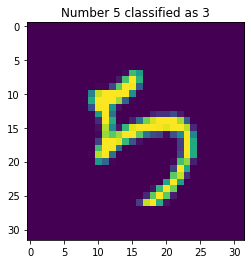

In [39]:
# Plot an incorrect value...
preds = LeNetMod.predict(cnn_x_test)
preds = np.argmax(preds, axis=1)
incorrectPreds = np.argwhere(preds != y_test)
randIncInd = np.random.choice(incorrectPreds.reshape(-1))
plt.imshow(cnn_x_test[randIncInd].reshape(32,32))
plt.title("Number {} classified as {}".format(y_test[randIncInd], preds[randIncInd]))

And further look to the confusion matrix for some idea of what's happening...

Text(95.72222222222221, 0.5, 'Actual')

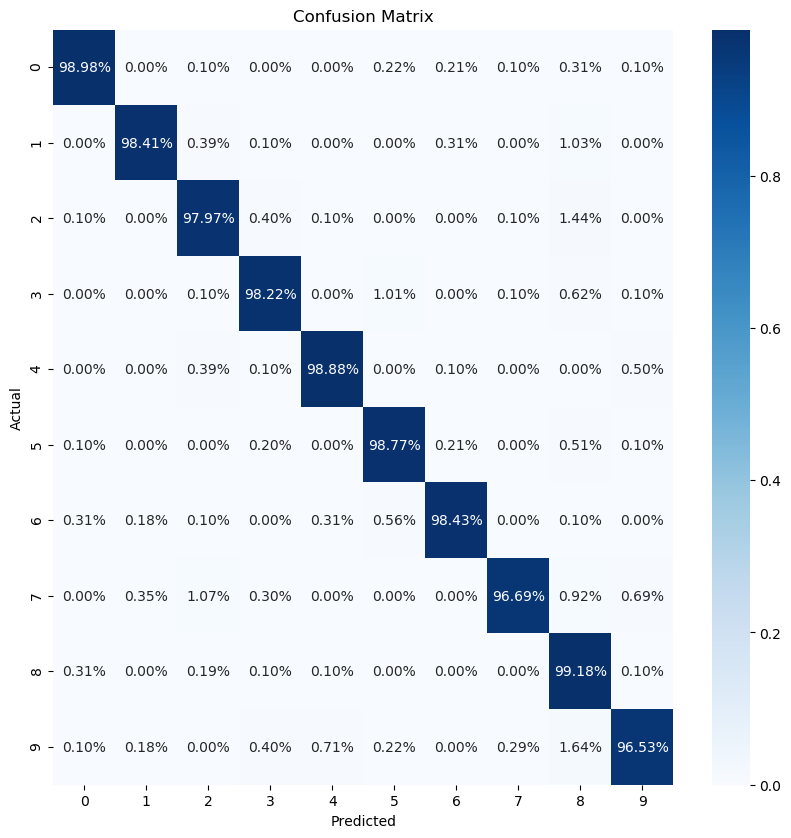

In [44]:
from sklearn.metrics import confusion_matrix
from seaborn import heatmap

conMat = confusion_matrix(y_test, preds)
plt.figure(figsize=(10,10), dpi=100)
heatmap(conMat/np.sum(conMat,axis=1), annot=True, fmt='.2%', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

Now, for the next part of this analysis, we will be using a gradient based tool in order to analyze the results of the classification. The reason for doing this is to gain the sort of "heat map" view that defines why a network chose to classify a given example with a particular class. This type of tool is usually the most useful for showing others how the network learns to identify certain classes. These types of techniques are often known as __saliency__ techniques as they help others assess the salient features of an image. We will be exploring the vanilla gradient technique for generating saliency maps along with the SmoothGrad algorithm (which is just a simple modification of the vanilla algorithm).

To begin, let us declare the class for saliency map generation...

In [38]:
from tensorflow.keras import backend as K

class SaliencyMap():
    ''' Defines a class for vanilla backpropagation + smoothgrad usage '''
    def __init__(self, model):
        # Sets up functions for gradient usage
        self.computeFeatGrads = [None] * model.output_shape[-1]
        for classInd in range(model.output_shape[-1]):
            grads = model.optimizer.get_gradients(model.get_layer('prelogits').output[0][classInd], model.input)
            self.computeFeatGrads[classInd] = K.function(inputs=model.input, outputs=grads)
    
    def getMap(self, inImage, imClass, normalized=False):
        ''' Calculates the vanilla gradient dy[feat]/dx for a given input '''
        xIn = np.expand_dims(inImage, axis=0)
        grads = self.computeFeatGrads[imClass](xIn)[0][0]
        return self.normalizeMap(grads, normalized)
    
    def getSmoothMap(self, inImage, imClass, stdevSpread=0.2, nSamples=50, normalized=False):
        ''' Averages perturbations accross an image to receive a less sparse saliency map '''
        stdev = stdevSpread * (np.max(inImage) - np.min(inImage))
        
        totalGrad = np.zeros_like(inImage)
        for i in range(nSamples):
            totalGrad += self.getMap(inImage + np.random.normal(0, stdev, inImage.shape), imClass)
            
        return self.normalizeMap(totalGrad/nSamples, normalized)
    
    def normalizeMap(self, inMap, normalized):
        if normalized:
            nMap = inMap - inMap.min()
            nMap /= nMap.max()
            return nMap
        else:
            return inMap

### Vanilla Gradient Saliency Maps - Algorithm
The vanilla gradient algorithm works as follows. For some given image $x_i$ pertaining to class $c$, we can generate the pre-logits predictions $S$ and loss $L$ given that image. In a typical backpropagation, the next step would be to calculate the gradient of the loss, $L$, with respect to the trainable weights and then apply them to the weights. However, the key part of this algorithm will be that since we want to observe the saliency with respect to a certain class, we will actually be calculating the gradient with respect to a particular pre-logits output, $S_c$ (although $c$ can be different if you wish to see why the network didn't classify it as some other class) up to the input.

To sum this up, we are simply calculating the following for the signed vanilla saliency map: $$ w = \frac{dS_c}{dx}\biggr\rvert_{x=x_i} $$

To acquire the more typical saliency map (that which looks like sparsely organized pixels in a black and white image, you will need to simply take the absolute value of the result, $M=\left|w\right|$. Since the image is small enough, we will only take a look at the signed saliency map in order to make some observations about the output. For more information on the vanilla gradient saliency map generation, take a look [here](https://arxiv.org/pdf/1312.6034.pdf).
$$$$
Of course, one problem with this classification is that generally small perturbations do not produce an exact derivative value. This is where SmoothGrad comes in: instead of calculating the derivative once, we perturb the network in many directions and then find the average derivative over all of these perturbations. The idea is that the more examples that are taken, the better the overall estimate of the derivative will be (in fact, the variance scales down at a rate of $\sqrt{n}$).

In [39]:
# Creates the saliency map class for a given classification model
salMod = SaliencyMap(LeNetMod)

Text(0.5, 1.0, 'Overlay')

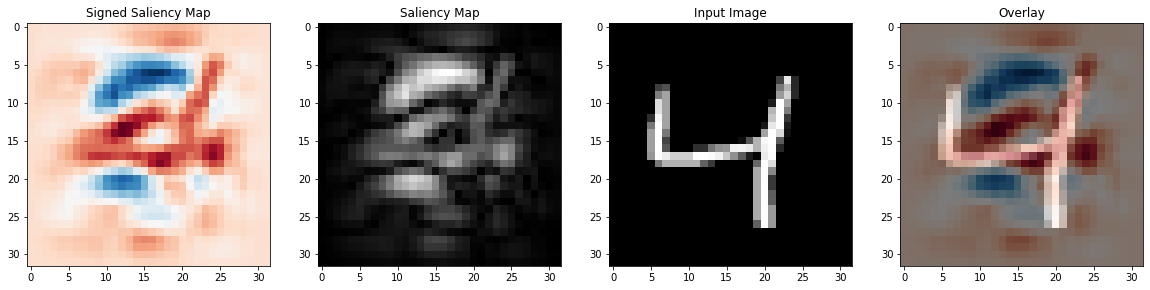

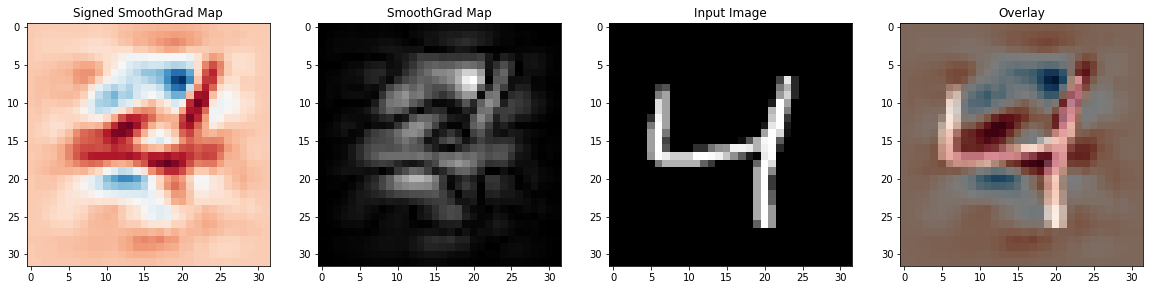

In [55]:
# Choose the image index here
ind = 2

# This handles the plotting of the saliency map along with the overlaying
salMap = salMod.getMap(cnn_x_train[ind], y_train[ind]).reshape(32,32)
plt.figure(figsize=(20,20))
plt.subplot(1,4,1)
plt.imshow(salMap, cmap='RdBu_r')
plt.title("Signed Saliency Map")
plt.subplot(1,4,2)
plt.imshow(np.abs(salMap), cmap='gray')
plt.title('Saliency Map')
plt.subplot(1,4,3)
plt.imshow(cnn_x_train[ind].reshape(32,32), cmap='gray')
plt.title("Input Image")
plt.subplot(1,4,4)
plt.imshow(salMap, cmap='RdBu_r')
plt.imshow(cnn_x_train[ind].reshape(32,32), cmap='gray', alpha=0.5)
plt.title("Overlay")

# This does the same as above, but for the SmoothGrad map
salMap = salMod.getSmoothMap(cnn_x_train[ind], y_train[ind], stdevSpread=.2).reshape(32,32)
plt.figure(figsize=(20,20))
plt.subplot(1,4,1)
plt.imshow(salMap, cmap='RdBu_r')
plt.title("Signed SmoothGrad Map")
plt.subplot(1,4,2)
plt.imshow(np.abs(salMap), cmap='gray')
plt.title('SmoothGrad Map')
plt.subplot(1,4,3)
plt.imshow(cnn_x_train[ind].reshape(32,32), cmap='gray')
plt.title("Input Image")
plt.subplot(1,4,4)
plt.imshow(salMap, cmap='RdBu_r')
plt.imshow(cnn_x_train[ind].reshape(32,32), cmap='gray', alpha=0.5)
plt.title("Overlay")

### Analysis
Given the above generated saliency maps, why do you think that the classifier has some trouble classifying particular numbers?